In [17]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import pickle
from datasets import Dataset
from tqdm import tqdm
import pandas as pd
from rlhfutils.rl_utils import scobow
from statistics import mean, stdev
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
import numpy as np

In [44]:
# Load the OPT model and tokenizer
model_name = "../../models/rewards/expbow50/"
# model_name = "facebook/opt-125m"
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map=3)

In [45]:
# Function to get embeddings
def get_embeddings(batch):
    inputs = tokenizer(batch, truncation=True, padding=True, return_tensors="pt", max_length=512).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states
    return hidden_states[-1].mean(dim=1).tolist()  # Return the average of the last layer's hidden states

def data_proc_embeds(dataset, batch_size=32): 
    jinps = ["Question: "+ex['question'].strip()+"\n\nAnswer: "+ex['response_j'].strip() for ex in dataset]
    kinps = ["Question: "+ex['question'].strip()+"\n\nAnswer: "+ex['response_k'].strip() for ex in dataset]
    j_embs = []
    k_embs = []
    for i in tqdm(range(0, len(jinps), batch_size)):
        j_embs.extend(get_embeddings(jinps[i:i+batch_size]))
        k_embs.extend(get_embeddings(kinps[i:i+batch_size]))
    dataset = dataset.add_column('j_embed', j_embs)
    dataset = dataset.add_column('k_embed', k_embs)
    return dataset

def process_dset(df, interv=2):
    # Prepare a list to store the new rows
    new_rows = []
    
    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        questions = row['inputs']
        responses = row['outputs']
        scores = row['goldrewards']
        for i in range(0, len(row['inputs']), interv): 
            j = i+1
            
            # TODO make interval logic more interesting
            assert questions[i]==questions[j]
            # Compare scores and assign to response_j/k and score_j/k
            if scores[i] > scores[j]:
                new_row = {'question':questions[i], 'response_j': responses[i], 'score_j': scores[i],
                           'response_k': responses[j], 'score_k': scores[j], 'rm_j': row['rewards'][i], 'rm_k':row['rewards'][j], 'step':row['step']}
            else:
                new_row = {'question':questions[i], 'response_j': responses[j], 'score_j': scores[j],
                           'response_k': responses[i], 'score_k': scores[i], 'rm_j': row['rewards'][j], 'rm_k':row['rewards'][i], 'step':row['step']}

            new_rows.append(new_row)
    return Dataset.from_list(new_rows)

def getfrac(dset, exs=1000, log=False): 
    inds = list(range(len(dset)))
    sampinds = random.sample(inds, exs)
    if log:
        print(sampinds[:20])
    return dset.select(sampinds)

In [6]:
bowtrain

NameError: name 'bowtrain' is not defined

In [41]:
oppairs = getfrac(oppairs, 1000)

In [48]:
bowtrain = pd.read_json("/u/prasanns/research/rlhf-length-biases/outputs/rollouts/dpoplusbow50rm.jsonl", orient='records', lines=True)
scolist = []
for i, row in tqdm(bowtrain.iterrows(), total=len(bowtrain)):
    uns = {}
    bowscos = [float(scobow(s, True, uns)) for s in row['outputs']]
    scolist.append(bowscos)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6526/6526 [00:37<00:00, 174.11it/s]


In [55]:
oppairs = process_dset(bowtrain)

In [36]:
oppairs = Dataset.load_from_disk("../../data/bow50rolloutdset50k")

In [50]:
bowtrain['goldrewards'] = scolist

In [15]:
dset = Dataset.load_from_disk("../../data/bowsynth50knozeros/")

In [46]:
tmp = data_proc_embeds(oppairs, 32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:17<00:00,  1.84it/s]
Loading cached processed dataset at /scratch/cluster/prasanns/research/rlhf-length-biases/data/bow50rolloutdset50k/cache-799ee98c3a98f332.arrow


In [47]:
tmp.save_to_disk("../../data/bowrolloutembedsopt50rmsmall")

In [26]:
embs1 = Dataset.load_from_disk("../../data/bowembedsoptrm50//")

In [30]:
embs2 = Dataset.load_from_disk("../../data/bowrolloutembedsoptrm50/")

In [13]:
embs1

Dataset({
    features: ['question', 'source', 'modj', 'modk', 'tokj', 'tok', 'response_j', 'response_k', 'magnitude', '__index_level_0__', 'score_j', 'score_k', 'j_embed', 'k_embed'],
    num_rows: 49884
})

In [55]:
tmp = tmp.sort('step')

Loading cached sorted indices for dataset at /scratch/cluster/prasanns/research/rlhf-length-biases/data/bow50rolloutdset50k/cache-1af5bcff0e190f74.arrow


In [56]:
newvals = np.concatenate((vals, np.array(tmp['j_embed'][:100] + tmp['k_embed'][:100])))

In [27]:
vals = np.array(embs1['j_embed'][:100] + embs1['k_embed'][:100])
vals.shape

(200, 768)

In [28]:
X_embedded.shape

(200, 2)

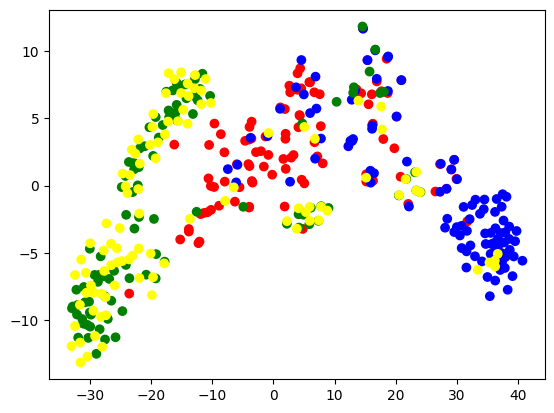

In [57]:
# Fit the t-SNE model
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(newvals)

# Plot the resultse
import matplotlib.pyplot as plt
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color=['red']*100 + ['blue']*100 + ['green']*100 + ['yellow']*100 )
plt.show()

In [18]:
tmp = get_embeddings(["hi there", "bye there"])

In [ ]:
dset = get_embeddings()

In [ ]:
# TODO crank up the efficiency

In [ ]:
# Example dataset
dataset = ["Sample text 1", "Sample text 2", ...]  # Replace with your actual dataset

# Get embeddings for the dataset
embeddings = [get_embeddings(text) for text in dataset]

# Save embeddings to a pickle file
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)